In [1]:
import pandas as pd
import numpy as np
import pickle
import altair as alt
from aoc import timeit
%load_ext autoreload
%autoreload 2

def load(filename):
    f = open(filename,"rb")
    return pickle.load(f)
    
def save(model, filename='bestmodel.pickle'):
    with open('output/'+filename, 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

def save_feature_selection(cols, filename='feat_selection.pickle'):
    with open('output/'+filename, 'wb') as handle:
        pickle.dump(cols, handle, protocol=pickle.HIGHEST_PROTOCOL)

def submit(model):
    pred = model.predict(final_test)
    final_test['SalePrice'] = np.exp(pred)
    final_test[['Id','SalePrice']].to_csv('output/submission.csv', index=False)

## Import data

In [2]:
f = open("output/engineered_datasets.pickle","rb")
train_x, train_y, final_test, num_x, cat_x, cat_x_ind = pickle.load(f)
f = open("output/feat_selection.pickle","rb")
cols = pickle.load(f)

## Import preprocessing pipelines & models

In [3]:

from utils.sklearn_custom_steps import DFSimpleImputer, DFOneHotEncoder,DFMinMaxScaler,DFColumnTransformer,DFOutlierExtractor,DFOutlierExtractor,DFStandardScaler,DFRobustScaler,DFSmartImputer, DFUnSkewer, DFPowerTransformer
from utils.sklearn_custom_steps import get_pipeline
from utils.model_hyperparameters import models

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet,SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import cross_validate
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from utils.model_hyperparameters import AutoCatBoostRegressor

## CV methods

In [4]:
def cross_val_models(to_test,train_x=train_x,**kwargs):
    for name in to_test:
        print(f"{name.ljust(20)}", end = ': ')
        pipe = get_pipeline(models[name].model, **models[name].preprocess, **kwargs)
        test_pipeline(pipe, train_x = train_x)
         
def test_model(model,train_x = train_x,param=None):
    if not param: param = {}
    pipe = get_pipeline(model,**param)
    return test_pipeline(pipe, train_x=train_x)

def test_pipeline(pipe,train_x = train_x):
    # print(train_x.shape)
    num_fold = 5
    
    scores = cross_validate(pipe, train_x, train_y, scoring='neg_root_mean_squared_error', cv=num_fold, return_train_score=True)
    print(f"test {-1 * sum(scores['test_score'])/num_fold:.7f}, train {-1 * sum(scores['train_score'])/num_fold:.7f}")
    return pipe

## Trying to hyperparameter search on preprocessing pipeline

In [5]:
f = open("output/hyperparam_tuning.pickle","rb")
results = pickle.load(f)
def get_estimator(model_name, results):
    model = get_pipeline(models[model_name].model, **models[model_name].preprocess)
    model.set_params(**results[model_name].best_params_)
    return model

In [11]:
def hyperparam_search_pipeline(model_name, pipe):
   print('start', model_name)
   param_grid = {
      # 'preprocess__col_trans__category_cat_to_num': [DFOneHotEncoder(handle_unknown="ignore")],
      # 'preprocess__col_trans__numeric__unskew_num' : [DFUnSkewer(),'passthrough'],
      'preprocess__col_trans__numeric__scale_num' : [DFStandardScaler(),DFRobustScaler(),DFMinMaxScaler(),DFPowerTransformer()],
      'preprocess__col_trans__numeric__impute_num__strategy': ['mean','median','most_frequent'],
      'preprocess__col_trans__category__impute_cat__strategy': ['most_frequent','constant']}
   search = GridSearchCV(pipe, param_grid, cv=5,scoring='neg_root_mean_squared_error',verbose=1).fit(train_x[cols], train_y)
   frame =pd.DataFrame(search.cv_results_)
   frame.sort_values(by='rank_test_score', inplace=True)
   return frame
pipe_search = dict()
for model_name in results:
   pipe_search[model_name] = hyperparam_search_pipeline(model_name, get_estimator(model_name, results))
   save(pipe_search,  'hyperparam_pipe.pickle')


start AutoCatBoostRegressor
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 22.1min finished
start ElasticNet
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.0min finished
start KernelRidge
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.2min finished
start Lasso
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   37.2s finished
start xgb.XGBRegressor
Fitting 5 folds for each of 24 candidates, totalli

In [10]:
pipe_search = load('output/hyperparam_pipe.pickle')
for model_name, res in pipe_search.items():
    res = res.reset_index()
    print(model_name)
    print('best score', res['mean_test_score'][0])
    print('best params', 
        res['param_preprocess__col_trans__category__impute_cat__strategy'][0],
        res['param_preprocess__col_trans__numeric__impute_num__strategy'][0],
        res['param_preprocess__col_trans__numeric__scale_num'][0],
    )

AutoCatBoostRegressor
best score -0.1153902521105318
best params constant mean DFMinMaxScaler
ElasticNet
best score -0.11587168950921545
best params most_frequent median DFStandardScaler
KernelRidge
best score -0.11674511912812666
best params most_frequent median DFStandardScaler
Lasso
best score -0.1158660391027462
best params most_frequent median DFStandardScaler
xgb.XGBRegressor
best score -0.11712434284626357
best params most_frequent most_frequent DFMinMaxScaler
lgb.LGBMRegressor
best score -0.11844457036420222
best params constant median DFRobustScaler


## Test of all models

In [11]:
# full dataset
for model_name in results:
    print(model_name)
    test_pipeline(get_estimator(model_name, results),train_x=train_x)

AutoCatBoostRegressor
test 0.1167024, train 0.0267797
ElasticNet
test 0.1176089, train 0.0997127
KernelRidge
test 0.1211799, train 0.1044793
Lasso
test 0.1175548, train 0.0994643
xgb.XGBRegressor
test 0.1217188, train 0.0448069
lgb.LGBMRegressor
test 0.1217541, train 0.0508283


In [12]:
# selected columns dataset
for model_name in results:
    print(model_name)
    test_pipeline(get_estimator(model_name, results),train_x=train_x[cols])

AutoCatBoostRegressor
test 0.1153903, train 0.0287469
ElasticNet
test 0.1158717, train 0.1040336
KernelRidge
test 0.1167451, train 0.1066567
Lasso
test 0.1158660, train 0.1038959
xgb.XGBRegressor
test 0.1171243, train 0.0469092
lgb.LGBMRegressor
test 0.1184446, train 0.0548421


## Hyperparameter tuning

In [5]:
from skopt import BayesSearchCV, callbacks
from skopt.space import Real, Categorical, Integer

TRAIN_TIME = 600
NUM_ITERATIONS = 150
NO_IMPROVEMENT_STOP_THRES = 25

def gen_opt_settings(model_name):
    model = {'model': [models[model_name].model]}
    for k,v in models[model_name].hyper.items():
        model['model__'+k] = v
    if models[model_name].hyper:
        return (model, NUM_ITERATIONS)
    else:
        return (model, 1)

def optimize_model(model_name,train_x = train_x):
    print('running', model_name)
    def no_improvement_detector(optim_result):
        score = opt.best_score_
        # print(optim_result.x)
        print(f"{'best score':15}{score}")
        if score > opt.train_status['current_score']:
            opt.train_status['current_score'] = score
            opt.train_status['not_improving'] = 0
        else:
            opt.train_status['not_improving'] += 1
            if opt.train_status['not_improving'] == opt.train_status['stop_thres']: return True
    checkpointsaver = callbacks.CheckpointSaver("output/" + model_name + "_skopt.pkl")
    deadlinestopper = callbacks.DeadlineStopper(TRAIN_TIME)

    opt = BayesSearchCV(
        get_pipeline(models[model_name].model, remove_outliers=True,**models[model_name].preprocess),
        [gen_opt_settings(model_name)],
        cv=5, 
        scoring = 'neg_root_mean_squared_error',
        return_train_score = True,
        random_state = 112,
        refit=False
        )
    opt.train_status = { 'current_score': -100, 'not_improving': 0, 'stop_thres' :NO_IMPROVEMENT_STOP_THRES}
    opt.fit(train_x,train_y, callback = [no_improvement_detector,checkpointsaver,deadlinestopper])
    return opt

def hashing(self): return 8398398478478 
CatBoostRegressor.__hash__ = hashing # otherwise skopt flips

to_test = [k for k in models]
to_test = [
    'AutoCatBoostRegressor',
    'ElasticNet',
    'KernelRidge',
    'Lasso',
    'xgb.XGBRegressor',
    'lgb.LGBMRegressor']
results = {}
for name in to_test:
    results[name] = optimize_model(name, train_x[cols])
save(results,'hyperparam_tuning.pickle')

running AutoCatBoostRegressor
best score     -0.11641185569473839
best score     -0.11641185569473839
best score     -0.11641185569473839
best score     -0.11641185569473839
best score     -0.11641185569473839
best score     -0.11542037635655349
best score     -0.11542037635655349
best score     -0.11542037635655349
best score     -0.11542037635655349
best score     -0.11542037635655349
best score     -0.11542037635655349
best score     -0.11539512363254882
running ElasticNet
best score     -0.15393657287023294
best score     -0.13211646538693064
best score     -0.12002794479755505
best score     -0.12002794479755505
best score     -0.11699816004982205
best score     -0.11699816004982205
best score     -0.11699816004982205
best score     -0.11699816004982205
best score     -0.11699816004982205
best score     -0.11699816004982205
best score     -0.11699816004982205
best score     -0.11699816004982205
best score     -0.11699816004982205
best score     -0.11699816004982205
best score     

In [5]:
f = open("output/hyperparam_tuning.pickle","rb")
results = pickle.load(f)

In [13]:
#summarize tuning results
for model in results:
    best_run = results[model].cv_results_['rank_test_score'].index(1)
    mean_test_score = -1 * results[model].cv_results_['mean_test_score'][best_run]
    std_test_score = results[model].cv_results_['std_test_score'][best_run]
    mean_train_score = -1 * results[model].cv_results_['mean_train_score'][best_run]
    mean_score_time = results[model].cv_results_['mean_score_time'][best_run]
    best_params = results[model].best_params_
    print(f"{model:<30} Best score {mean_test_score:.4f} std {std_test_score:.4f} train {mean_train_score:.4f} time {mean_score_time:.4f}")

AutoCatBoostRegressor          Best score 0.1154 std 0.0062 train 0.0287 time 0.0474
ElasticNet                     Best score 0.1159 std 0.0119 train 0.1040 time 0.1059
KernelRidge                    Best score 0.1168 std 0.0104 train 0.1067 time 0.1179
Lasso                          Best score 0.1159 std 0.0119 train 0.1039 time 0.0895
xgb.XGBRegressor               Best score 0.1177 std 0.0090 train 0.0468 time 0.1028
lgb.LGBMRegressor              Best score 0.1190 std 0.0085 train 0.0544 time 0.0870


## Stacking best models from hyperparam

In [11]:
from sklearn.ensemble import StackingRegressor

def get_estimator(model_name):
    model = get_pipeline(models[model_name].model, **models[model_name].preprocess)
    model.set_params(**results[model_name].best_params_)
    return model

to_stack_list = [
    'AutoCatBoostRegressor',
    'ElasticNet',
    'KernelRidge',
    'Lasso',
    'xgb.XGBRegressor',
    'lgb.LGBMRegressor']

# to_stack_list = to_test
# to_stack = [(model_name, results[model_name].best_estimator_) for model_name in to_stack_list]
# to_stack = [(model_name, results[model_name].best_estimator_) for model_name in results]
to_stack = [(model_name, get_estimator(model_name)) for model_name in to_stack_list]
model = StackingRegressor(to_stack, final_estimator = (LinearRegression()), passthrough = False)
num_fold = 5
scores = cross_validate(model, train_x[cols], train_y, scoring='neg_root_mean_squared_error', cv=num_fold, return_train_score=True)
print(f"stacking model train {-1 * sum(scores['train_score'])/num_fold:.4f}, test {-1 * sum(scores['test_score'])/num_fold:.4f}")
model.fit(train_x[cols],train_y)
save(model,'ensemble.pickle')

stacking model train 0.0577, test 0.1115


## Blending, to get rid of some of the overfitting

In [13]:
f = open("output/ensemble.pickle","rb")
model = pickle.load(f)

In [12]:
preds = [estimator.predict(final_test) for estimator in model.estimators_]
weights = np.array([0.1]*len(preds) + [(1-len(preds)*0.1)])
preds.append(model.predict(final_test))
print(len(preds))
# weigh the individual models with 0.1 and the stacked regressor with the remainder
weighted_preds = preds * weights[:, None]
final_preds = np.sum(weighted_preds,axis=0)
final_test['SalePrice'] = np.exp(final_preds)
final_test[['Id','SalePrice']].to_csv('output/blend_submission.csv', index=False)

7


## Saving

In [7]:
# model = get_pipeline(CatBoostRegressor(silent=True,cat_features=cat_x),onehot=False)
# model = model.fit(train_x,train_y)
submit(model)
save(model,'ensemble.pickle')

## FastAI
This first try didn't really give me good results

In [66]:
import fastai2
# from fastai2.tabular.all import *
f = open("output/engineered_datasets.pickle","rb")
train_x, train_y, final_test, num_x, cat_x, cat_x_ind = pickle.load(f)
df = train_x
df['SalePrice'] = train_y

In [67]:
num_x,cat_x = cont_cat_split(df, max_card=9000, dep_var='SalePrice')

In [69]:
dls = TabularDataLoaders.from_df(df, path='bla', y_names="SalePrice",
    cat_names = cat_x,
    cont_names = num_x,
    procs = [Categorify, FillMissing, Normalize])

In [70]:
learn = tabular_learner(dls, layers=[1000,500], loss_func=F.mse_loss, # or func MSELossFlat()
                        config=tabular_config(ps=[0.001,0.01], embed_p=0.04), 
                        metrics=rmse)

learn = tabular_learner(dls, loss_func=MSELossFlat(), 
                        metrics=rmse)

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.00363078061491251)

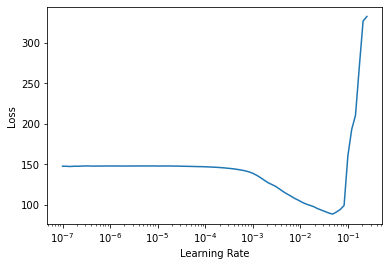

In [71]:
learn.lr_find()

In [87]:
learn.fit_one_cycle(15, 6.918309954926372e-05, wd=0.2)

epoch,train_loss,valid_loss,_rmse,time
0,0.720350,1.260966,1.122927,00:07
1,0.634628,1.274511,1.128943,00:06
2,0.633233,1.154903,1.074664,00:06
3,0.722872,1.229494,1.108825,00:06
4,0.635765,0.975592,0.987721,00:07
5,0.672587,1.005359,1.002676,00:06
6,0.610774,1.013499,1.006727,00:06
7,0.514983,0.915475,0.956805,00:06
8,0.512361,0.657616,0.810935,00:07
9,0.509264,0.903293,0.950417,00:06


In [88]:
final_test['BsmtFinSF1'] = final_test['BsmtFinSF1'].fillna(0)
final_test['BsmtFinSF2'] = final_test['BsmtFinSF2'].fillna(0)
final_test['BsmtUnfSF'] = final_test['BsmtUnfSF'].fillna(0)
final_test['TotalBsmtSF'] = final_test['TotalBsmtSF'].fillna(0)
final_test['BsmtFullBath'] = final_test['BsmtFullBath'].fillna(0)
final_test['KitchenQual'] = final_test['KitchenQual'].fillna(train_x['KitchenQual'].mean())
final_test['Functional'] = final_test['Functional'].fillna(train_x['Functional'].mean())
final_test['GarageCars'] = final_test['GarageCars'].fillna(0)
final_test['GarageArea'] = final_test['GarageArea'].fillna(0)
final_test['SimplFunctional'] = final_test['SimplFunctional'].fillna(0)
final_test['SimplKitchenQual'] = final_test['SimplKitchenQual'].fillna(0)
final_test['KitchenScore'] = final_test['KitchenScore'].fillna(0)
final_test['SimplFunctional'] = final_test['SimplFunctional'].fillna(train_x['SimplFunctional'].mean())
final_test['SimplKitchenScore'] = final_test['SimplKitchenScore'].fillna(train_x['SimplKitchenScore'].mean())
final_test['TotalBath'] = final_test['TotalBath'].fillna(1)
final_test['AllSF'] = final_test['AllSF'].fillna(train_x['AllSF'].mean())
final_test['AllSF_2'] = final_test['AllSF_2'].fillna(train_x['AllSF_2'].mean())
final_test['AllSF_3'] = final_test['AllSF_3'].fillna(train_x['AllSF_3'].mean())
final_test['AllSF_sq'] = final_test['AllSF_sq'].fillna(train_x['AllSF_sq'].mean())
final_test['GarageCars_2'] = final_test['GarageCars_2'].fillna(train_x['GarageCars_2'].mean())
final_test['GarageCars_3'] = final_test['GarageCars_3'].fillna(train_x['GarageCars_3'].mean())
final_test['GarageCars_sq'] = final_test['GarageCars_sq'].fillna(train_x['GarageCars_sq'].mean())
final_test['TotalBath_2'] = final_test['TotalBath_2'].fillna(train_x['TotalBath_2'].mean())
final_test['TotalBath_3'] = final_test['TotalBath_3'].fillna(train_x['TotalBath_3'].mean())
final_test['TotalBath_sq'] = final_test['TotalBath_sq'].fillna(train_x['TotalBath_sq'].mean())
final_test['TotalBath_sq'] = final_test['TotalBath_sq'].fillna(train_x['TotalBath_sq'].mean())
final_test['KitchenQual_2'] = final_test['KitchenQual_2'].fillna(train_x['KitchenQual_2'].mean())
final_test['KitchenQual_3'] = final_test['KitchenQual_3'].fillna(train_x['KitchenQual_3'].mean())
final_test['KitchenQual_sq'] = final_test['KitchenQual_sq'].fillna(train_x['KitchenQual_sq'].mean())
final_test['BsmtFinSF1_log'] = final_test['BsmtFinSF1_log'].fillna(train_x['BsmtFinSF1_log'].mean())
final_test['BsmtFinSF2_log'] = final_test['BsmtFinSF2_log'].fillna(train_x['BsmtFinSF2_log'].mean())
final_test['BsmtUnfSF_log'] = final_test['BsmtUnfSF_log'].fillna(train_x['BsmtUnfSF_log'].mean())
final_test['TotalBsmtSF_log'] = final_test['TotalBsmtSF_log'].fillna(train_x['TotalBsmtSF_log'].mean())
final_test['BsmtFullBath_log'] = final_test['BsmtFullBath_log'].fillna(train_x['BsmtFullBath_log'].mean())
final_test['TotalBsmtSF_log'] = final_test['TotalBsmtSF_log'].fillna(train_x['TotalBsmtSF_log'].mean())
final_test['BsmtHalfBath_log'] = final_test['BsmtHalfBath_log'].fillna(train_x['BsmtHalfBath_log'].mean())
final_test['GarageCars_log'] = final_test['GarageCars_log'].fillna(train_x['GarageCars_log'].mean())
final_test['GarageArea_log'] = final_test['GarageArea_log'].fillna(train_x['GarageArea_log'].mean())
final_test['AllSF_log'] = final_test['AllSF_log'].fillna(train_x['AllSF_log'].mean())
final_test['BsmtHalfBath'] = final_test['BsmtHalfBath'].fillna(train_x['BsmtHalfBath'].mean())

# test_to = to.new(final_test)
# test_to.process()

In [89]:
final_test['MiscFeature']=np.nan
dl = learn.dls.test_dl(final_test)
res= learn.get_preds(dl=dl)

In [90]:
final_test['SalePrice'] = np.exp(res[0].numpy())
final_test[['Id','SalePrice']].to_csv('output/submission.csv', index=False)

In [91]:
final_test['SalePrice'][:100]

0      67190.859375
1      16630.333984
2      49383.144531
3      77657.109375
4     110854.671875
          ...      
95     55282.664062
96     88132.164062
97     85025.382812
98     67225.734375
99     12819.370117
Name: SalePrice, Length: 100, dtype: float32

## Borutashap for feature selection
Let it run for n_trials. After a dictionary is returned with:
- accepted: columns with information
- tentative: not sure yet
- rejected: columns not better than max shadow
- selected: accepted + tentative

https://medium.com/analytics-vidhya/is-this-the-best-feature-selection-algorithm-borutashap-8bc238aa1677

In [54]:
f = open("output/engineered_datasets.pickle","rb")
train_x, train_y, final_test, num_x, cat_x, cat_x_ind = pickle.load(f)

from BorutaShap import BorutaShap
from utils.model_hyperparameters import AutoCatBoostRegressor
cat = CatBoostRegressor(max_depth=5,silent=True)

# with onehot = False, this leads to lower amount of columns. But a CatBoostRegressor does need way more time to do the onehot encoding manually
# however it's very nice to see the categorical columns
pipe = get_pipeline(BorutaShap(model = cat, importance_measure='shap',
                              classification=False, pvalue=0.005),onehot=False)
feat_selector = pipe.fit(train_x,train_y,model__n_trials=50)

100%|██████████| 50/50 [43:42<00:00, 52.46s/it]30 50 100 (accept,tentative,reject)
30 attributes confirmed important: ['OverallQual_sq', 'TotalSF_log', 'BsmtExposure', 'LotArea_log', 'TotalSF', 'OverallQual_3', 'AllPorchSF', 'OverallCond', 'YearRemodAdd_log', 'OverallQual', 'CentralAir', 'OverallQual_2', 'AllSF_sq', 'Total_sqr_footage', 'TotalBath_2', 'YrBltAndRemod', 'GarageFinish', 'MSZoning', 'Neighborhood', 'OverallGrade', 'YearBuilt', 'AllSF', 'LotArea', 'YearRemodAdd', 'GarageYrBlt', 'SaleCondition', 'AllSF_2', 'Condition1', 'AllSF_3', 'GarageType']
100 attributes confirmed unimportant: ['SimplBsmtFinType2', 'GarageScore_2', 'MasVnrType', 'MasVnrArea', 'GarageScore_3', 'MiscVal', 'EnclosedPorch', '3SsnPorch_log', 'BoughtOffPlan', 'ExterGrade', 'BsmtFullBath', 'LotConfig', 'KitchenScore', 'BldgType', 'BsmtHalfBath', 'GarageGrade', 'Fence', 'Street', 'OpenPorchSF_log', 'TotalBsmtSF', 'SimplExterQual', 'WoodDeckSF', 'SimplGarageQual', 'Alley', 'MoSold', 'HalfBath_log', 'SimplExterCo

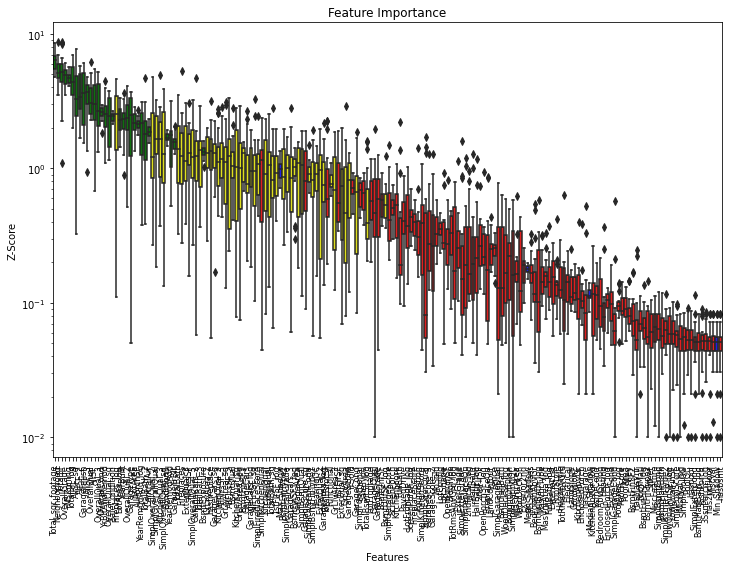

In [57]:
feat_selector.named_steps['model'].plot(which_features='all', 
                      X_size=8, figsize=(12,8),
                      y_scale='log')

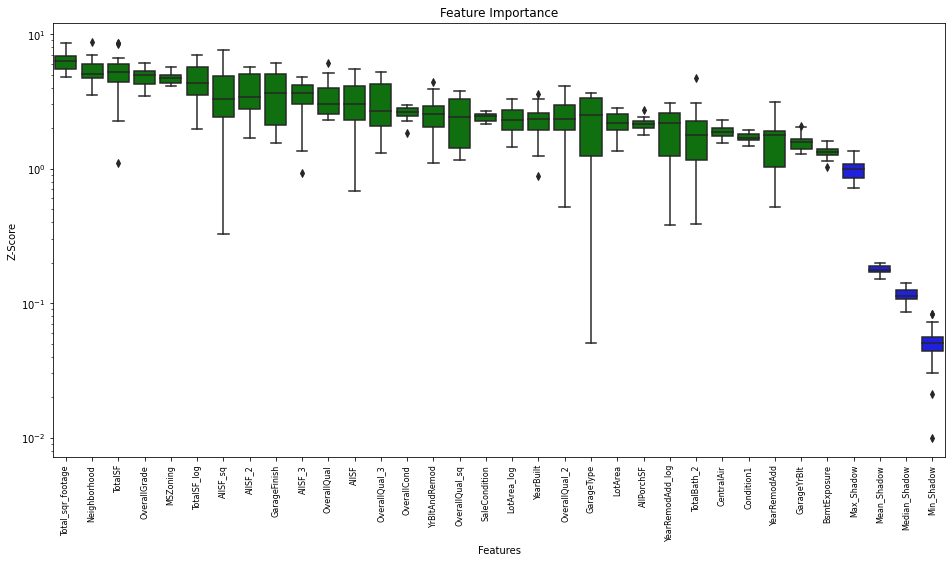

In [58]:
feat_selector.named_steps['model'].plot(which_features='accepted', 
                      X_size=8, figsize=(16,8),
                      y_scale='log')

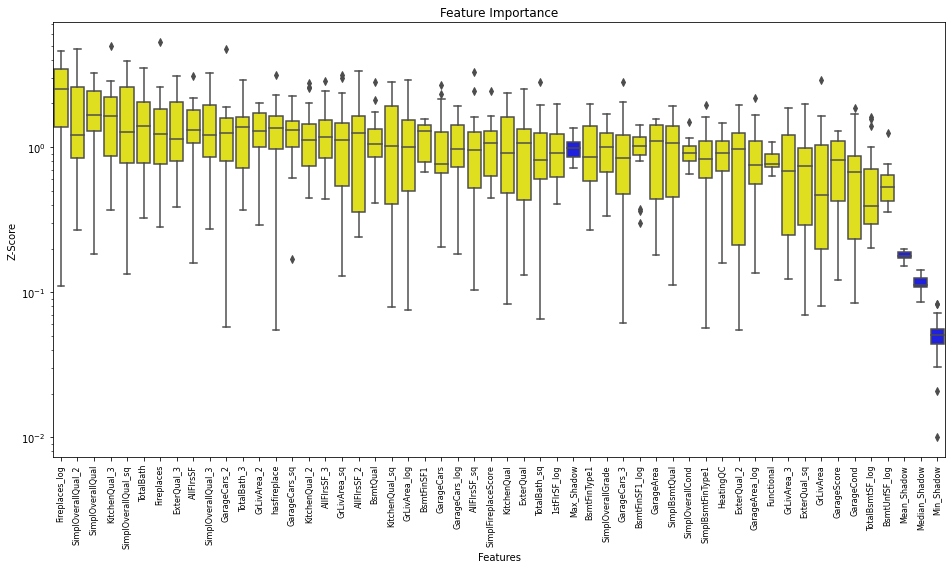

In [59]:
feat_selector.named_steps['model'].plot(which_features='tentative', 
                      X_size=8, figsize=(16,8),
                      y_scale='log')

In [55]:
# check which run works best. Note that CV has quite high variance. Accepted columns are not giving better results
to_test = [lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.02, n_estimators=500,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11,random_state=42),
            Lasso(alpha=0.0005304432735934807)]
for model in to_test:
    print('baseline')
    test_model(model,train_x=train_x)
    for i in [16,26,49]:
        cols = feat_selector.named_steps['model'].runs[i]['accepted']
        print('run',i, 'num cols',len(cols), end=':')
        test_pipeline(get_pipeline(Lasso(alpha=0.0005304432735934807)),train_x=train_x[cols])


baseline
test 0.1252954, train 0.0971292
run 16 num cols 20:test 0.1385009, train 0.1147986
run 26 num cols 26:test 0.1295277, train 0.1139556
run 49 num cols 30:test 0.1299457, train 0.1132598
baseline
test 0.1162317, train 0.0969346
run 16 num cols 20:test 0.1385009, train 0.1147986
run 26 num cols 26:test 0.1295277, train 0.1139556
run 49 num cols 30:test 0.1299457, train 0.1132598


In [56]:
# Selected columns do slightly better
    print('baseline')
    test_model(model,train_x=train_x)
    for i in [16,26,49]:
        cols = set(feat_selector.named_steps['model'].runs[i]['selected'])
        print('run',i, 'num cols',len(cols), end=':')
        test_pipeline(get_pipeline(Lasso(alpha=0.0005304432735934807)),train_x=train_x[cols])

baseline
test 0.1252954, train 0.0971292
run 16 num cols 104:test 0.1164337, train 0.1026415
run 26 num cols 88:test 0.1169684, train 0.1045752
run 49 num cols 80:test 0.1165569, train 0.1048845
baseline
test 0.1162317, train 0.0969346
run 16 num cols 104:test 0.1164337, train 0.1026415
run 26 num cols 88:test 0.1169684, train 0.1045752
run 49 num cols 80:test 0.1165569, train 0.1048845


In [62]:
cols = feat_selector.named_steps['model'].runs[16]['selected']
save(cols, filename='feat_selection.pickle')

In [9]:
results['Lasso'].bestestimator['model']

Pipeline(memory=None,
         steps=[('preprocess',
                 Pipeline(memory=Memory(location=C:\Users\Jesse\AppData\Local\Temp\tmp381l72ql\joblib),
                          steps=[('col_trans',
                                  DFColumnTransformer(n_jobs=None,
                                                      remainder='drop',
                                                      sparse_threshold=0.3,
                                                      transformer_weights=None,
                                                      transformers=[('numeric',
                                                                     Pipeline(memory=None,
                                                                              steps=[('impute_num',
                                                                                      DFSimpleImputer(add_indicator=False, copy...
                                                                     <sklearn.compose._column_trans